<a href="https://www.sanger.ac.uk/about/who-we-are/"><img src = "https://www.sanger.ac.uk/wp-content/uploads/jan2018__wellcome_sanger_institute_logo_landscape_digital_rgb_full_colour-800x275.png" width = 400> </a>

<p style="text-align: center;"><font size = 5>Studying variation in government response to COVID-19</font></p><br>
<p style="text-align: justify;"><font size = 2>Studying variation in government response to COVID-19 is important to understand the dynamics of viral pandemics, but also to best advise health policy makers. This report makes use of two publicly available curated datasets containing number of daily COVID-19 cases and deaths worldwide and a variety of government response actions to COVID-19 (including closing down of public schools, workplace, etc).</font></p>


# Project set-up 
## Importing packages 

In [1]:
#import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install xlrd
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install geopy
#!{sys.executable} -m pip install plotly

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

import math

# Sci-kit learn for modelling
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from  geopy.geocoders import Nominatim

import plotly.express as px

print('Libraries imported.')

Libraries imported.


## User-defined functions 

In [2]:
## Functions
def removeNull(df):
    print('Initial record size: {}'.format(df.shape[0]))
    df = df[df['CountryCode'].isnull() == False] # No country code
    print('Final record size: {}'.format(df.shape[0]))
    return df

def calculateEpidemiology(df):
    """
    This function is used to calculate cumulative number of Cases, cumulative incidence and cumulative number of Deaths
    in the COVID-19 dataset.
    """
    cumCases = df.groupby(['CountryCode', 'Date']).sum().groupby(level=0).cumsum().reset_index()['Cases']    
    df['cumIncidence'] = (df['Cases'] / df['PopData2019']) * 100000 # cumulative incidence , per 100,000 habitants
    cumIncidence = df.groupby(['CountryCode', 'Date']).sum().groupby(level=0).cumsum().reset_index()['cumIncidence']  
    cumDeaths = df.groupby(['CountryCode', 'Date']).sum().groupby(level=0).cumsum().reset_index()['Deaths']
    return cumCases, cumIncidence, cumDeaths

def transformWide(df, epidem, cols):
    """
    This function is used to calculate cumulative number of Cases, cumulative incidence and cumulative number of Deaths
    in the COVID-19 dataset.
    """
    df_wide = df.pivot(index = 'CountryCode', columns = 'Date', values = epidem)[cols]
    return df_wide.fillna('0.0').astype(float) # replacing NaN values with zero and converting to float

def plotTop10(top10, epidem):
    """
    This function is used to plot the top 10 countries with higher cumulative Cases, higher cumulative incidence
    and higher cumulative Deaths.
    """
    if epidem == 'cumCases':
        name = 'cumulative Cases'
    elif epidem == 'cumIncidence':
        name = 'cumulative incidence (logarithmic scale)'
    elif epidem == 'cumDeaths':
        name = 'cumulative Deaths'
    else:
        print('Wrong arguments!')

    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.suptitle('Top 10 countries with highest COVID-19 {}'.format(name), fontsize=12)


    # Divide the figure into a 2x1 grid, and give me the first section
    ax1 = fig.add_subplot(121)

    # Divide the figure into a 2x1 grid, and give me the second section
    ax2 = fig.add_subplot(122)

    if epidem == 'cumIncidence':
        covid_cumIncidence.loc['GBR'].plot(ax=ax1, legend=True, color = 'purple')
        ax1.set_ylabel(name)
        ax1.set_xlabel("Date")
    else:
        top10.loc['GBR'].plot(ax=ax1, legend=True, color = 'purple')
        ax1.set_ylabel(name)
        ax1.set_xlabel("Date")

    for index,_ in top10.iterrows():
        top10.loc[index].plot(ax=ax2, legend=True)
        ax2.set_xlabel("Date")

    plt.savefig('epidemiological_covid2019_{}'.format(name), dpi = 400)


def maxRate(df, periods):
    """
    This function calculates the first derivative of the number of cumulative Cases/Deaths.
    As these are cumulative Cases over times, this gives us the daily infection rate.
    Then we can find the maximum infection rate for all countries.
    """
    countries = df.index
    max_rates = []
    for c in countries:
        max_rates.append(df.diff(axis = 1 , periods = periods).loc[c].max()) 
    return max_rates



def plotMaxRate(df):
    """
    This function is used to plot the top 10 countries with highest infection/death rates.
    """
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    fig.suptitle('Top 10 countries with highest COVID-19 maximum daily infection/death rates over 14-day periods',\
                 fontsize=16)

    # Divide the figure into a 2x1 grid, and give me the first section
    ax1 = fig.add_subplot(121)

    # Divide the figure into a 2x1 grid, and give me the second section
    ax2 = fig.add_subplot(122)

    Deaths = df.sort_values(by = 'MaxDeathRate', ascending = False)['MaxDeathRate']
    infections = df.sort_values(by = 'MaxInfectionRate', ascending = False)['MaxInfectionRate']
    labels_Deaths = df.sort_values(by = 'MaxDeathRate', ascending = False).reset_index()['CountryCode']
    labels_infections = df.sort_values(by = 'MaxInfectionRate', ascending = False).reset_index()['CountryCode']
    y_pos_Deaths = np.arange(df.sort_values(by = 'MaxDeathRate', ascending = False).shape[0])
    y_pos_infection = np.arange(df.sort_values(by = 'MaxInfectionRate', ascending = False).shape[0])

    ax1.barh(y_pos_Deaths[0:10], Deaths[0:10])
    ax1.set_yticks(y_pos_Deaths[0:10])
    ax1.set_yticklabels(labels_Deaths[0:10], fontsize = 14)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_xlabel('Maximum daily death rate', fontsize = 14)

    ax2.barh(y_pos_infection[0:10], infections[0:10])
    ax2.set_yticks(y_pos_infection[0:10])
    ax2.set_yticklabels(labels_infections[0:10], fontsize = 14)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Maximum daily infection rate', fontsize = 14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("maximum_daily_death_and_infection_rates_COVID19.png", dpi = 400)


def plotInfectionRates(df, countries, periods):
    """
    This function takes a data frame with cumulative Cases and a list of countries, for which we want
    to plot the infection rate.
    """
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(10)

    for c in countries:
        np.log(df.diff(axis = 1, periods = periods).loc[c]).plot()

    plt.ylabel('Infection rate over 14-day periods\n(logarithmic scale)', fontsize = 14)
    plt.xlabel('Month', fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig("top10_infection_rates_COVI19.png", dpi = 400)
        
def plotGovernmentResponse(df, countries):

    for c in countries:       
        ax1 = plt.subplots(figsize = (10,6))[1]
        ax1.plot('Date', 'LogInfectionRate', data = df.loc[c])
        ax1.plot('Date', 'LogDeathRate', data = df.loc[c])
        ax1.set_title(c, loc = 'left', fontsize = 14)
        ax1.legend(loc = 'upper left', fontsize = 12)
        ax1.set_ylabel("Infection/death rates over 14-day periods\n(logarithmic scale)", fontsize = 14)
        ax1.set_xlabel("Date", fontsize = 14)
        ax1.set_ylim(0, 12)
        ax1_2 = ax1.twinx()
        ax1_2.plot('Date', 'GovernmentResponseIndex', data = df.loc[c], color = "#ff7f0e")
        ax1_2.legend(loc='upper left',  bbox_to_anchor=(0, 0.8), fontsize = 12)
        ax1_2.set_ylabel("Government response Index", fontsize = 14)
        ax1_2.set_ylim(0, 100)
        plt.savefig("covid_response_government_{}.png".format(c), dpi = 400)
        
        
def geoLocate(countries):
    """
    This function uses geopy to determine center coordinates of countries, using the three-letter country code.
    """
    coord = []
    geolocator = Nominatim(user_agent = "world_explorer")
    for country in countries: # march and june have the same indices
        try:
            # To geolocate the city and country
            loc = geolocator.geocode(country)
            # And return latitude and longitude
            coord.append((loc.latitude, loc.longitude))
        except:
            # Return missing value
            coord.append(np.nan)
    return coord 

## Download the datasets: 
### [Data on the geographic distribution of COVID-19 cases worldwide](https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590)

<blockquote cite="https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data">
  <p>The dataset contains the latest available public data on COVID-19 including a daily situation update, the epidemiological curve and the global geographical distribution (EU/EEA and the UK, worldwide).

On 12 February 2020, the novel coronavirus was named severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) while the disease associated with it is now referred to as COVID-19. Since the beginning of the coronavirus pandemic, ECDC’s Epidemic Intelligence team has been collecting on daily basis the number of COVID-19 cases and deaths, based on reports from health authorities worldwide. To insure the accuracy and reliability of the data, this process is being constantly refined. This helps to monitor and interpret the dynamics of the COVID-19 pandemic not only in the European Union (EU), the European Economic Area (EEA), but also worldwide. Every day between 6.00 and 10.00 CET, a team of epidemiologists screens up to 500 relevant sources to collect the latest figures. The data screening is followed by ECDC’s standard epidemic intelligence process for which every single data entry is validated and documented in an ECDC database. An extract of this database, complete with up-to-date figures and data visualisations, is then shared on the ECDC website, ensuring a maximum level of transparency.</p> <br>
    <footer> <cite> European Centre for Disease Prevention and Control </cite>
        </footer>
</blockquote>

In [3]:
!wget -q -O 'covid_data.csv' https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
!wget -q -O 'gov_response_data.csv' https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv
   
print('Data downloaded!')

Data downloaded!


In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

with open('covid_data.csv') as csv_data:
    covid = pd.read_csv(csv_data,  parse_dates=['dateRep'], date_parser=dateparse) 
   
print('The dataset has {} records on {} unique countries and terrories.'.format(
        covid.shape[0],
        len(covid['countryterritoryCode'].unique())
    )
)

covid.head()

The dataset has 26771 records on 210 unique countries and terrories.


dateRep  day  month  year  cases  deaths countriesAndTerritories geoId  \
0 2020-06-30   30      6  2020    271      12             Afghanistan    AF   
1 2020-06-29   29      6  2020    351      18             Afghanistan    AF   
2 2020-06-28   28      6  2020    165      20             Afghanistan    AF   
3 2020-06-27   27      6  2020    276       8             Afghanistan    AF   
4 2020-06-26   26      6  2020    460      36             Afghanistan    AF   

  countryterritoryCode  popData2019 continentExp  
0                  AFG   38041757.0         Asia  
1                  AFG   38041757.0         Asia  
2                  AFG   38041757.0         Asia  
3                  AFG   38041757.0         Asia  
4                  AFG   38041757.0         Asia

### [The Oxford COVID-19 Government Response Tracker (OxCGRT) ](https://www.bsg.ox.ac.uk/sites/default/files/2020-05/BSG-WP-2020-032-v6.0.pdf)

<blockquote cite="https://www.bsg.ox.ac.uk/sites/default/files/2020-05/BSG-WP-2020-032-v6.0.pdf">
  <p>COVID-19 has prompted a wide range of responses from governments
around the world. There is a pressing need for up-to-date policy information as these
responses proliferate, and governments weigh decisions about the stringency of their
policies against other concerns. We introduce the Oxford COVID-19 Government
Response Tracker (OxCGRT), providing a systematic way to track government
responses to COVID-19 across countries and time. We combine this data into a series of
novel indices that aggregate various measures of government responses. These indices
are used to describe variation in government responses, explore whether the
government response affects the rate of infection, and identify correlates of more or
less intense responses.</p> <br>
<footer> <cite> Thomas Hale, Sam Webster, Anna Petherick,
Toby Phillips, and Beatriz Kira. (2020). Oxford COVID-19 Government Response Tracker.
Blavatnik School of Government. Available: www.bsg.ox.ac.uk/covidtracker </cite>
</footer>
</blockquote>


In [5]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d')

with open('gov_response_data.csv') as csv_data:
    gov_res = pd.read_csv(csv_data,  parse_dates=['Date'], date_parser=dateparse) 
   
print('The dataset has {} records on {} unique countries.'.format(
        gov_res.shape[0],
        len(gov_res['CountryCode'].unique())
    )
)

gov_res.head()

The dataset has 32396 records on 178 unique countries.


CountryName CountryCode       Date  C1_School closing  C1_Flag  \
0       Aruba         ABW 2020-01-01                0.0      NaN   
1       Aruba         ABW 2020-01-02                0.0      NaN   
2       Aruba         ABW 2020-01-03                0.0      NaN   
3       Aruba         ABW 2020-01-04                0.0      NaN   
4       Aruba         ABW 2020-01-05                0.0      NaN   

   C2_Workplace closing  C2_Flag  C3_Cancel public events  C3_Flag  \
0                   0.0      NaN                      0.0      NaN   
1                   0.0      NaN                      0.0      NaN   
2                   0.0      NaN                      0.0      NaN   
3                   0.0      NaN                      0.0      NaN   
4                   0.0      NaN                      0.0      NaN   

   C4_Restrictions on gatherings  ...  StringencyIndex  \
0                            0.0  ...              0.0   
1                            0.0  ...              0.0   
2                            0.0  ...              0.0   
3                            0.0  ...              0.0   
4                            0.0  ...              0.0   

   StringencyIndexForDisplay  StringencyLegacyIndex  \
0                        0.0                    0.0   
1                        0.0                    0.0   
2                        0.0                    0.0   
3                        0.0                    0.0   
4                        0.0                    0.0   

   StringencyLegacyIndexForDisplay  GovernmentResponseIndex  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   

   GovernmentResponseIndexForDisplay  ContainmentHealthIndex  \
0                                0.0                     0.0   
1                                0.0                     0.0   
2                                0.0                     0.0   
3                                0.0                     0.0   
4                                0.0                     0.0   

   ContainmentHealthIndexForDisplay  EconomicSupportIndex  \
0                               0.0                   0.0   
1                               0.0                   0.0   
2                               0.0                   0.0   
3                               0.0                   0.0   
4                               0.0                   0.0   

   EconomicSupportIndexForDisplay  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 42 columns]

## Data preparation
First, I will rename columns tp a more readable format and drop some unwanted values/columns:

In [6]:
## Covid data
# Remove unwanted columns
covid.drop(['day', 'month', 'year', 'geoId'], axis = 1, inplace = True)

# Change column names to more readable format
covid.rename(columns = {'dateRep': 'Date', 'countriesAndTerritories':'Countries', 'countryterritoryCode':'CountryCode', \
                       'cases':'Cases', 'deaths':'Deaths', 'popData2019':'PopData2019', 'continentExp':'Continent'},
            inplace = True)

covid = removeNull(covid)

covid.sort_values(by = ['CountryCode', 'Date'], inplace = True)

covid.head()

Initial record size: 26771
Final record size: 26707


Date  Cases  Deaths Countries CountryCode  PopData2019 Continent
1263 2020-03-13      2       0     Aruba         ABW     106310.0   America
1262 2020-03-20      2       0     Aruba         ABW     106310.0   America
1261 2020-03-24      8       0     Aruba         ABW     106310.0   America
1260 2020-03-25      5       0     Aruba         ABW     106310.0   America
1259 2020-03-26      2       0     Aruba         ABW     106310.0   America

In [7]:
## Governement response data
gov_res = gov_res[['CountryCode', 'StringencyIndex', 'GovernmentResponseIndex', \
                       'ContainmentHealthIndex', 'EconomicSupportIndex', 'Date']]

gov_res = removeNull(gov_res)

gov_res.sort_values(by = ['CountryCode', 'Date'], inplace = True)

Initial record size: 32396
Final record size: 32396


Then, I will calculate the cumulative number of cases, since this dataset contains number of new cases per day:

In [8]:
cumCases = pd.DataFrame(calculateEpidemiology(covid)[0])
cumIncidence = pd.DataFrame(calculateEpidemiology(covid)[1])
cumDeaths = pd.DataFrame(calculateEpidemiology(covid)[2])

covid.set_index('CountryCode', inplace = True)

cumCases.index=covid.index
cumIncidence.index=covid.index
cumDeaths.index=covid.index

covid['cumCases'] = cumCases
covid['cumIncidence'] = np.log(cumIncidence)
covid['cumDeaths'] = cumDeaths

covid.head()

Date  Cases  Deaths Countries  PopData2019 Continent  \
CountryCode                                                              
ABW         2020-03-13      2       0     Aruba     106310.0   America   
ABW         2020-03-20      2       0     Aruba     106310.0   America   
ABW         2020-03-24      8       0     Aruba     106310.0   America   
ABW         2020-03-25      5       0     Aruba     106310.0   America   
ABW         2020-03-26      2       0     Aruba     106310.0   America   

             cumIncidence  cumCases  cumDeaths  
CountryCode                                     
ABW              0.631958         2          0  
ABW              1.325105         4          0  
ABW              2.423717        12          0  
ABW              2.772024        17          0  
ABW              2.883250        19          0

Then transform to wide format:

In [9]:
cols = covid.sort_values(by = 'Date', ascending = True)['Date'].unique()
covid_cumCases = transformWide(covid.reset_index(), 'cumCases', cols)
covid_cumDeaths = transformWide(covid.reset_index(), 'cumDeaths', cols)
covid_cumIncidence = transformWide(covid.reset_index(), 'cumIncidence', cols)
covid_cumCases.head() # Example

Date         2019-12-31  2020-01-01  2020-01-02  2020-01-03  2020-01-04  \
CountryCode                                                               
ABW                 0.0         0.0         0.0         0.0         0.0   
AFG                 0.0         0.0         0.0         0.0         0.0   
AGO                 0.0         0.0         0.0         0.0         0.0   
AIA                 0.0         0.0         0.0         0.0         0.0   
ALB                 0.0         0.0         0.0         0.0         0.0   

Date         2020-01-05  2020-01-06  2020-01-07  2020-01-08  2020-01-09  ...  \
CountryCode                                                              ...   
ABW                 0.0         0.0         0.0         0.0         0.0  ...   
AFG                 0.0         0.0         0.0         0.0         0.0  ...   
AGO                 0.0         0.0         0.0         0.0         0.0  ...   
AIA                 0.0         0.0         0.0         0.0         0.0  ...   
ALB                 0.0         0.0         0.0         0.0         0.0  ...   

Date         2020-06-21  2020-06-22  2020-06-23  2020-06-24  2020-06-25  \
CountryCode                                                               
ABW               101.0       101.0       101.0       101.0       101.0   
AFG             28424.0     28833.0     29143.0     29481.0     29715.0   
AGO               172.0       176.0       183.0       186.0       189.0   
AIA                 3.0         3.0         3.0         3.0         3.0   
ALB              1891.0      1927.0      1995.0      2047.0      2114.0   

Date         2020-06-26  2020-06-27  2020-06-28  2020-06-29  2020-06-30  
CountryCode                                                              
ABW               101.0       101.0       101.0       101.0       103.0  
AFG             30175.0     30451.0     30616.0     30967.0     31238.0  
AGO               197.0       212.0       244.0       267.0       276.0  
AIA                 3.0         3.0         3.0         3.0         3.0  
ALB              2192.0      2269.0      2330.0      2402.0      2466.0  

[5 rows x 183 columns]

# Exploratory Data Analysis

## What are the top 10 countries with higher COVID-19 cumulative daily cases, cumulative incidence and cumulative deaths?

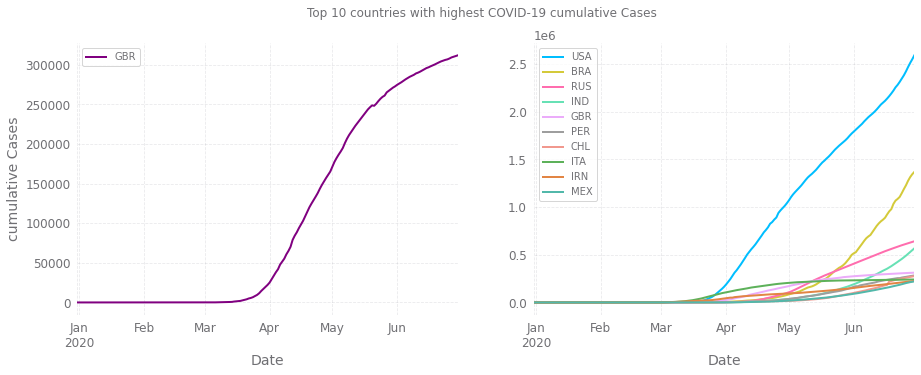

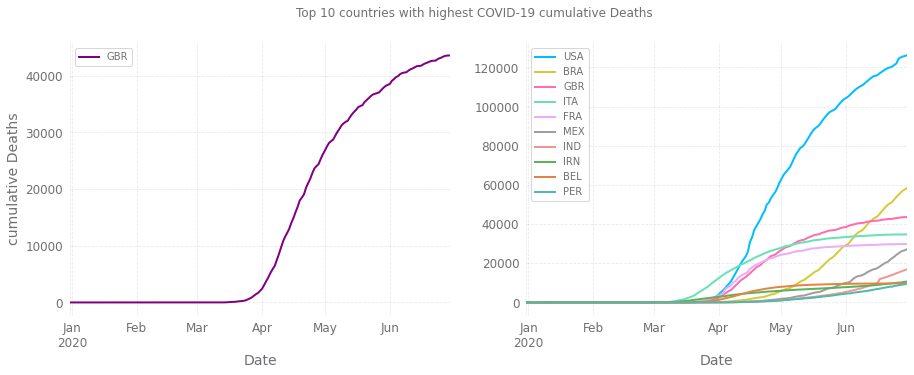

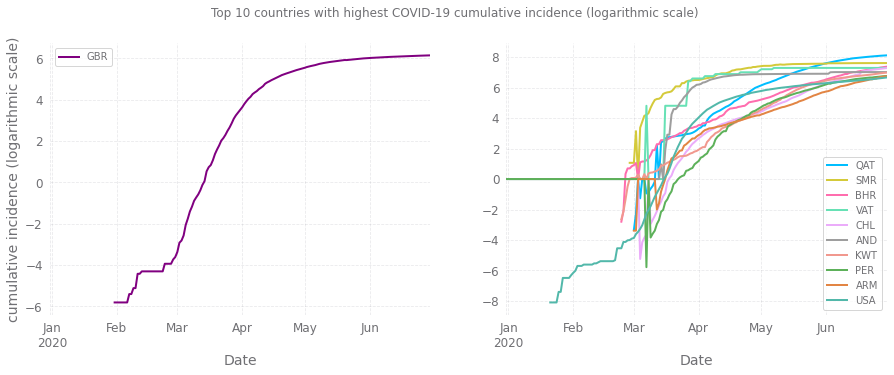

In [10]:
top10_cumCases = covid_cumCases.sort_values(by = cols[-1], ascending = False)[0:10]
top10_cumDeaths = covid_cumDeaths.sort_values(by = cols[-1], ascending = False)[0:10]
top10_cumIncidence = covid_cumIncidence.sort_values(by = cols[-1], ascending = False)[0:10]

plotTop10(top10_cumCases, 'cumCases')
plotTop10(top10_cumDeaths, 'cumDeaths')
plotTop10(top10_cumIncidence, 'cumIncidence')

> Note: The results for the cumulative incidence may be slightly underestimated, particularly for countries with hight death rates, since I did not take into account the people who have died. 

## What are the top 10 countries with highest maximum COVID-19 infection and death rate? 
The top 10 countries with maximum infection/death rates:

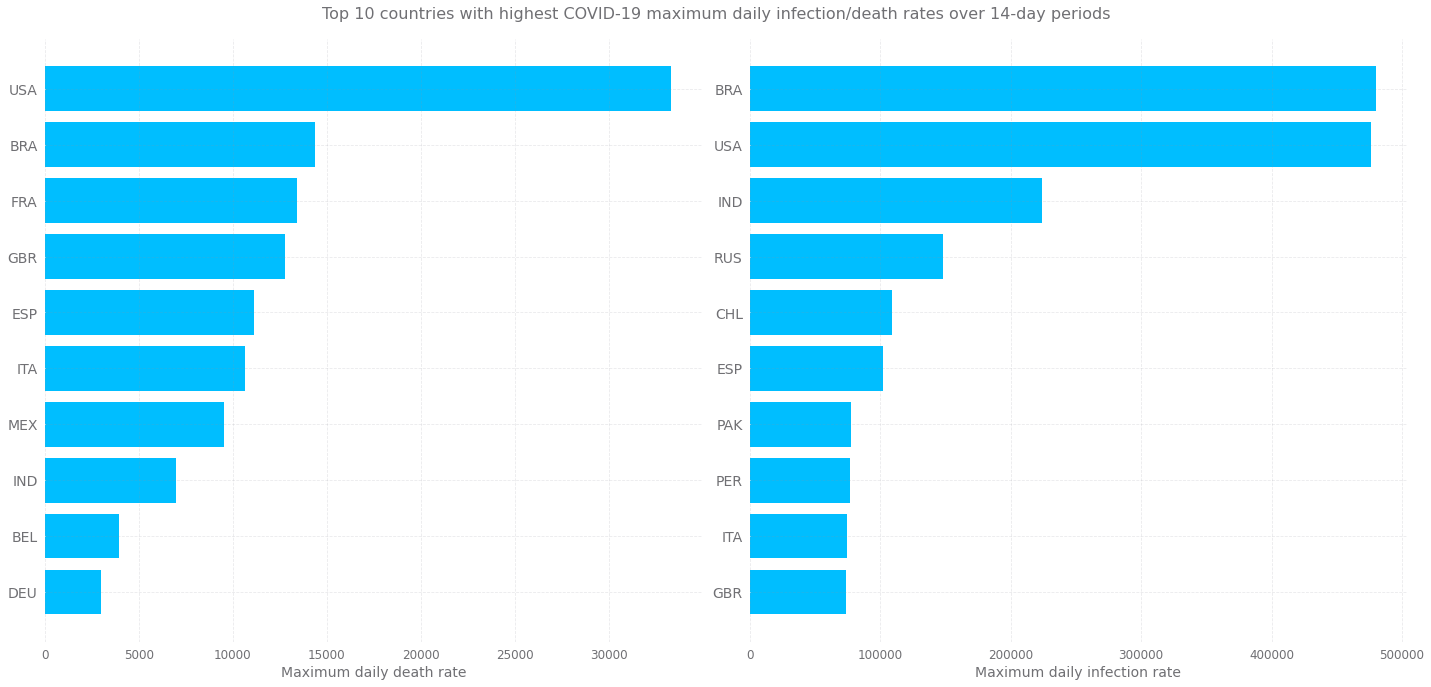

In [11]:
# Maximum rate
covid_max_rate = {'MaxInfectionRate': maxRate(covid_cumCases, periods = 14),\
                  'MaxDeathRate': maxRate(covid_cumDeaths, periods = 14)}
covid_max_rate = pd.DataFrame(covid_max_rate)
covid_max_rate.index = covid_cumCases.index # same index

plotMaxRate(covid_max_rate)    

> Of course these maximum might not correspond to the same day. For better comparison, perhaps it would be useful to plot the mean of infection/death rates...

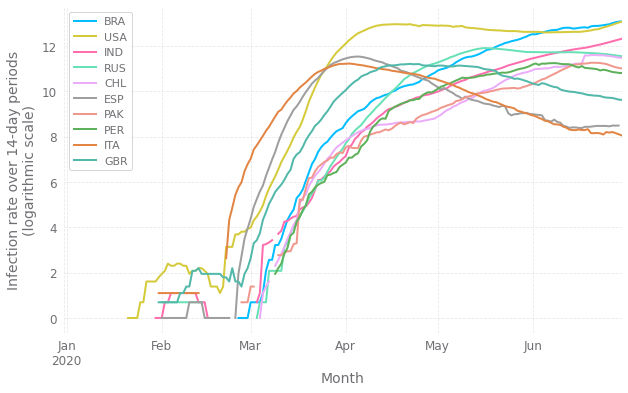

In [12]:
countries_max = list(covid_max_rate.sort_values(by = 'MaxInfectionRate', ascending = False)[0:10].index)
plotInfectionRates(covid_cumCases, countries_max, periods = 14)

# Research question: which government response components were more effective in stopping/slowing down the COVID-19 pandemic? 


## Variability in time and stringency of government responses to COVID-19

In [13]:
# Selecting dates I want to plot graph for
march_june_gov_res = gov_res[(gov_res['Date'] > '2020-03-01') & (gov_res['Date'] < '2020-06-01')].set_index('CountryCode')

# Plot map animation 
fig = px.choropleth(march_june_gov_res,
                    locations = march_june_gov_res.index,
                    color = march_june_gov_res['GovernmentResponseIndex'],
                    hover_name = march_june_gov_res.index,
                    color_continuous_scale=px.colors.sequential.Blues,
                    animation_frame= march_june_gov_res['Date'].dt.strftime("%Y-%m-%d"),
                    projection = 'equirectangular',
                    title = 'Government response stringency in response to COVID-19, from March to June 2020'
                    
) 

fig.show()

### Visualizing relationship between government response index and infection/death rates. Case example: Great Britain vs New Zealand

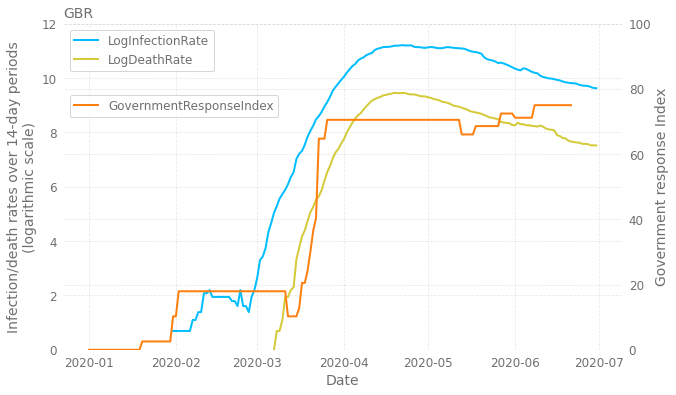

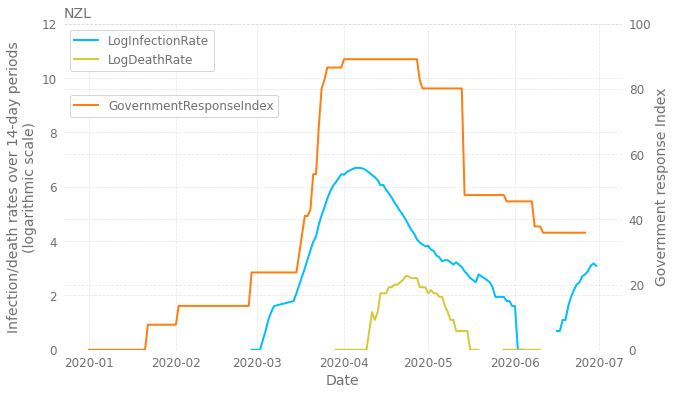

In [14]:
covid['InfectionRate'] = cumCases.groupby('CountryCode').diff(axis = 0, periods = 14)
covid['DeathRate'] = cumDeaths.groupby('CountryCode').diff(axis = 0, periods = 14)

covid_gov_res =  pd.merge(gov_res, covid[['Date', 'InfectionRate', 'DeathRate', 'PopData2019', 'Continent']].reset_index(),  how='inner', left_on=['CountryCode', 'Date'], right_on = ['CountryCode', 'Date'])
covid_gov_res.set_index('CountryCode', inplace = True)

covid_gov_res['LogInfectionRate'] =  np.log(covid_gov_res['InfectionRate'])
covid_gov_res['LogDeathRate'] =  np.log(covid_gov_res['DeathRate'])

# Visualize for USA and New Zealand
plotGovernmentResponse(covid_gov_res, ['GBR', 'NZL'])

> Looks like New Zealand initial policies differed from the USA, in a way that they were not in response to the infection rates, but always anticipating them. 

#### Correlation between infection rate and government response

> Another way to visualize relationship between infection/death rates and government responses is to plot scatter plot. 

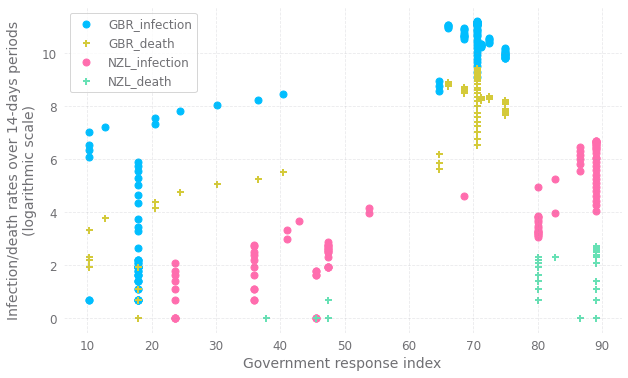

In [15]:
fig = plt.figure(figsize = (10, 6))
plt.scatter(y = 'LogInfectionRate', x = 'GovernmentResponseIndex', data = covid_gov_res.loc['GBR'], label = 'GBR_infection')
plt.scatter(y = 'LogDeathRate', x = 'GovernmentResponseIndex', data = covid_gov_res.loc['GBR'], label = 'GBR_death', marker = '+')
plt.scatter(y = 'LogInfectionRate', x = 'GovernmentResponseIndex', data = covid_gov_res.loc['NZL'], label = 'NZL_infection')
plt.scatter(y = 'LogDeathRate', x = 'GovernmentResponseIndex', data = covid_gov_res.loc['NZL'], label = 'NZL_death', marker = '+')
plt.ylabel('Infection/death rates over 14-days periods\n(logarithmic scale)', fontsize = 14)
plt.xlabel('Government response index', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc = 0, fontsize = 12)

> We can clearly see the almost linear relationship between infection/death rates and government responses, with New Zealand showing tougher measures at lower infection rates. 

### Modelling government responses as a function of maximum infection rates 
> Althought these are longitudinal data, I will start simple, modelling maximum infection rates as a function of more stringent government responses, using linear regression. 

In [16]:
"""
Feature selection:
1. Earliest time point for tougher measures (continuous) OR
2. Maximum government response index (continuous)?
3. Population number (continous)?
4. Geographical location - continent (categorical)?
""" 

max_gov_idx = covid_gov_res[covid_gov_res.groupby('CountryCode')['GovernmentResponseIndex'].transform(np.nanmax) == covid_gov_res['GovernmentResponseIndex']]
max_gov_idx = max_gov_idx.groupby('CountryCode').first()[['GovernmentResponseIndex', 'LogInfectionRate']]
max_gov_idx

GovernmentResponseIndex  LogInfectionRate
CountryCode                                           
ABW                            79.49          4.143135
AFG                            64.74          6.107023
AGO                            75.64          2.833213
ALB                            81.41          4.882802
AND                            63.46          3.044522
...                              ...               ...
VNM                            85.90          4.624973
YEM                            40.38          1.609438
ZAF                            85.26          9.593151
ZMB                            63.14          4.043051
ZWE                            71.15          2.079442

[170 rows x 2 columns]

Visualizing relationships:

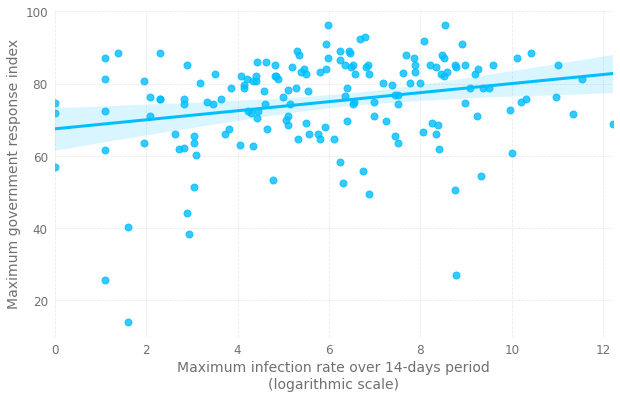

In [17]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
max_gov_idx = max_gov_idx[~max_gov_idx.isin([np.nan, np.inf, -np.inf]).any(1)]
sns.regplot(x = 'LogInfectionRate', y = 'GovernmentResponseIndex', data = max_gov_idx)
plt.xlabel('Maximum infection rate over 14-days period\n(logarithmic scale)', fontsize = 14)
plt.ylabel('Maximum government response index', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('correlation_maximum_government_response_maximum_infection_rate.png', dpi = 400)

> Although the results won't differ too much, to avoid overfitting I will perform linear regression under 5-fold cross-validation design, so I can estimate the mean explained variance of the maximum infection rate explained by maximum government responses:

In [18]:
X = max_gov_idx[~max_gov_idx.isin([np.nan, np.inf, -np.inf]).any(1)]

y = X[['GovernmentResponseIndex']]

X = X[['LogInfectionRate']]

clf = make_pipeline(preprocessing.StandardScaler(), linear_model.LinearRegression())

cv = 5

print('The mean explained variance is: {} %'.format(round(cross_val_score(clf, X, y, cv = cv, scoring='explained_variance').mean() * 100, 2)))
print('The mean R2 is: {} %'.format(round(cross_val_score(clf, X, y, cv = cv, scoring='r2').mean() * 100, 2)))

The mean explained variance is: 6.48 %
The mean R2 is: 0.83 %


> Of course, more complex models will be needed to determine which strategies worked best to stop or slow-down the spread of the COVID-19 pandemic. Models that take into account the variability in time and stringency of government responses will be required to answer this question. 